In [2]:
import argparse
from ase import Atoms
from ase.io import read, write
from ase.optimize import *
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, ZeroRotation, Stationary
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from os.path import splitext
from ase.visualize import view
from ase.md.verlet import VelocityVerlet
import numpy as np
from NNCalculator.NNCalculator import *
import time

import ase
from ase import io
from ase.visualize import view

import matplotlib.pyplot as plt

from tqdm import tqdm

def dihedral3(p):
    b = p[:-1] - p[1:]
    b[0] *= -1
    v = np.array( [np.cross(v,b[1]) for v in [b[0], b[2]] ] )
    # Normalize vectors
    v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1,1)
    return np.degrees(np.arccos( v[0].dot(v[1]) ))

initial_pdb = io.read('minimized.pdb')

def vis_pdb(pdb):
    atomic_numbers = pdb.get_atomic_numbers()
    #  hack to get around the color scheme and atom type names
    #. eg. CYA for alpha carbon types
    pdb.set_atomic_numbers([ _ if _ != 20 else 6 
                            for _ in atomic_numbers])
    return view(pdb, viewer="x3d")


#

In [8]:
INPUT = "min.xyz"
OUTPUT = "opt_min.xyz"

In [3]:
atoms = read(INPUT)


In [3]:
# vis_pdb(atoms)

In [4]:
vis_pdb(initial_pdb)

In [5]:
atoms = initial_pdb

In [6]:
calc = NNCalculator(
    checkpoint="models/Ac-Ala3-NHMe-coff10-elec-disp-wf53-cw14-alldata-b", #load the model you want to used
    atoms=atoms,
    charge=0,
    F=128,
    K=64,
    num_blocks=5,
    num_residual_atomic=2,
    num_residual_interaction=3,
    num_residual_output=1,
    sr_cut=10.0,
    use_electrostatic=True,
    use_dispersion=True,
    s6=1.0000,                    #s6 coefficient for d3 dispersion, by default is learned
    s8=2.3550,                    #s8 coefficient for d3 dispersion, by default is learned
    a1=0.5238,                    #a1 coefficient for d3 dispersion, by default is learned
    a2=3.5016)                   #a2 coefficient for d3 dispersion, by default is learned)






/home/frei/.conda/envs/pyCHARMM/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from models/Ac-Ala3-NHMe-coff10-elec-disp-wf53-cw14-alldata-b


In [9]:
#attach the calculator object to the atoms object
atoms.set_calculator(calc)

#optimize
opt = BFGS(atoms)
opt.run(10**6)

#write output file
write(OUTPUT, atoms)

      Step     Time          Energy         fmax
BFGS:    0 01:42:15       -0.875020        1.4372


In [14]:
TEMP = 298
CHARGE = 0
STEPS = 10**6
TIMESTEP = 0.002
FRICTION = 0.02
INTERVAL = 20
filename = "dynamics"

In [15]:
#run an optimization
BFGS(atoms).run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 01:44:30       -0.759134        2.2148
BFGS:    1 01:44:30       -0.936318        1.3868
BFGS:    2 01:44:30       -1.004224        0.7957
BFGS:    3 01:44:30       -1.063607        0.5272
BFGS:    4 01:44:30       -1.097530        0.2984
BFGS:    5 01:44:30       -1.109082        0.2130
BFGS:    6 01:44:31       -1.124390        0.2564
BFGS:    7 01:44:31       -1.132921        0.2309
BFGS:    8 01:44:31       -1.140115        0.2448
BFGS:    9 01:44:31       -1.146145        0.2285
BFGS:   10 01:44:31       -1.151868        0.1977
BFGS:   11 01:44:31       -1.156304        0.1285
BFGS:   12 01:44:31       -1.158776        0.1022
BFGS:   13 01:44:31       -1.160138        0.0677
BFGS:   14 01:44:31       -1.161170        0.0725
BFGS:   15 01:44:31       -1.161961        0.0572
BFGS:   16 01:44:31       -1.162670        0.0698
BFGS:   17 01:44:31       -1.163332        0.0624
BFGS:   18 01:44:31       -1.163876        0.0501
B

True

In [ ]:
# Set the momenta corresponding to a temperature T
MaxwellBoltzmannDistribution(atoms, TEMP * units.kB)
ZeroRotation(atoms)
Stationary(atoms)

# define the algorithm for MD: here Langevin alg. with with a time step of 0.1 fs,
# the temperature T and the friction coefficient to 0.02 atomic units.
dyn = Langevin(atoms, TIMESTEP * units.fs, TEMP * units.kB, FRICTION)
#dyn = VelocityVerlet(atoms, args.timestep * units.fs)


def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
# save the positions of all atoms after every Xth time step.
traj = Trajectory(str(TEMP)+ 'K_md_' + filename + '.traj', 'w', atoms)

"""
#equilibration
for i in range(10000):
    if i%100 == 0:
        print("Equilibration Step: ", i)
    dyn.run(1)

"""
start_time = time.time()
# run the dynamics
for i in tqdm(range(STEPS)):
    dyn.run(1)
    if i%INTERVAL == 0:
        #epot = atoms.get_potential_energy() / len(atoms)
        #ekin = atoms.get_kinetic_energy() / len(atoms)
        # print("Production Step: ", i)
        traj.write()

end_time = time.time()


# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)
print("Time per step: ", elapsed_time / STEPS)

  3%|▎         | 29268/1000000 [09:11<5:12:08, 51.83it/s]

In [14]:
# traj.__dict__

In [23]:
intraj = Trajectory("298K_md_dynamics.traj")

/home/frei/.conda/envs/pyCHARMM/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


#  Analysis

In [36]:
coords = []
for i, atoms in enumerate(intraj):
    # print(i, atoms.positions)
    coords.append(atoms.positions)

/home/frei/.conda/envs/pyCHARMM/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Text(0, 0.5, '$\\psi$ Angle ($^{\\circ}$)')

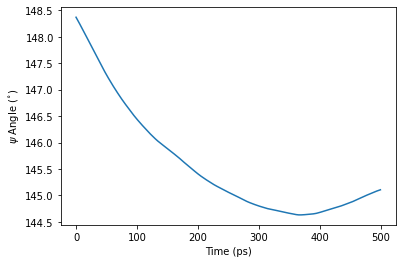

In [37]:
psi_idxs = [6,8,10,16]
# print(protein.getNames()[psi_idxs])
psidihs = [dihedral3(coords[i][psi_idxs]) for i
        in range(len(coords))]

plt.plot(range(len(psidihs)), psidihs)
plt.xlabel("Time (ps)")
plt.ylabel("$\psi$ Angle ($^{\circ}$)")


Text(0, 0.5, '$\\psi$ Angle ($^{\\circ}$)')

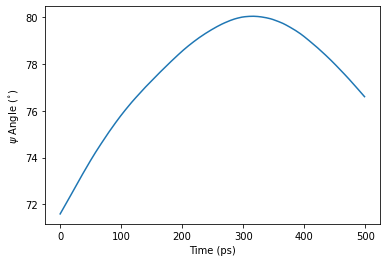

In [39]:
phi_idxs = [4,6,8,10]
phidihs = [dihedral3(coords[i][phi_idxs]) for i
        in range(len(coords))]

plt.plot(range(len(phidihs)), phidihs)
plt.xlabel("Time (ps)")
plt.ylabel("$\psi$ Angle ($^{\circ}$)")